In [1]:
project_root = None

In [ ]:
from pathlib import Path
import shap
import sys
import yaml
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

if project_root is None:
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path(project_root)
    
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.cleaner import DataCleaner
from src.data.loader import DataLoader
from src.models.supervised import LogisticModel, RandomForestModel, XGBoostModel
from src.evaluation.metrics import classification_metrics
from src.visualization.plots import plot_model_comparison, plot_confusion

with open(PROJECT_ROOT / "configs" / "params.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_PATH = PROJECT_ROOT / cfg["paths"]["raw_data"]
TARGET = cfg["target"]


In [3]:
df = DataLoader(DATA_PATH).load()
X, y, _ = DataCleaner().clean(df, target=TARGET)

In [4]:

models = {
    "LogisticRegression": LogisticModel(seed=cfg['seed']),
    "RandomForest": RandomForestModel(
        params=cfg["model"]["random_forest"],
        seed=cfg['seed']
    ),
    "XGBoostModel": XGBoostModel(
        params=cfg["model"]["xgboost"],
        seed=cfg['seed']
    )
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=cfg["test_size"],
    random_state=cfg['seed'],
    stratify=y
)

results = []

for name, model in models.items():
    print(f"Training {name}...")

    model.train(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    metrics = classification_metrics(y_test, y_pred, y_prob)
    metrics["Model"] = name

    results.append(metrics)

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
results_df


Training LogisticRegression...
Training RandomForest...
Training XGBoostModel...


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,Model
0,0.905085,0.771429,0.574468,0.658537,0.902282,0.756508,LogisticRegression
2,0.867797,0.653846,0.361702,0.465753,0.850806,0.631445,XGBoostModel
1,0.840678,0.000000,0.000000,0.000000,0.834677,0.548947,RandomForest


In [5]:
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

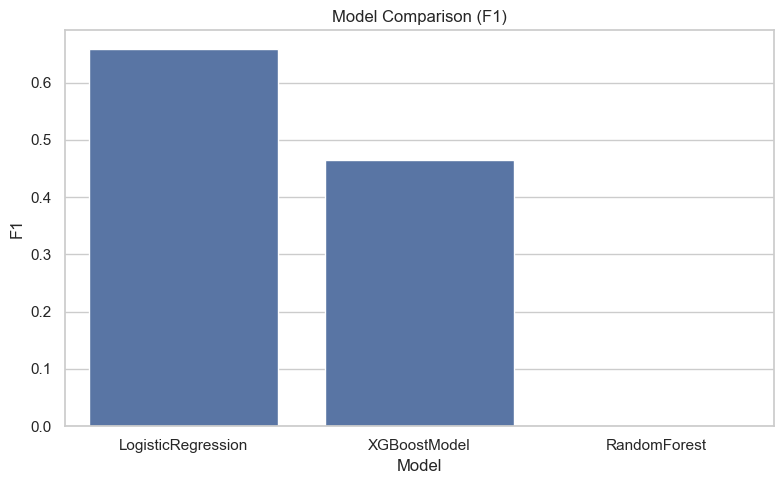

In [6]:
plot_model_comparison(
    results_df,
    metric="F1",
    save_path=FIG_DIR / "model_f1_comparison.png"
)


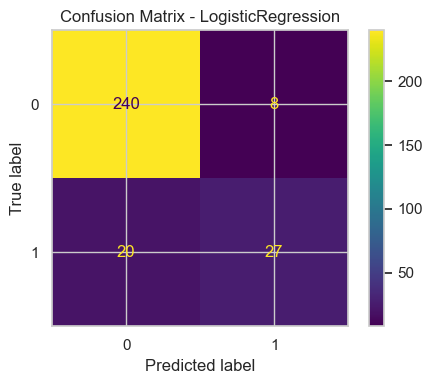

In [7]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

best_model.train(X_train, y_train)

y_pred_best = best_model.predict(X_test)

plot_confusion(
    y_test,
    y_pred_best,
    title=f"Confusion Matrix - {best_model_name}",
    save_path=FIG_DIR / "confusion_matrix_best_model.png"
)


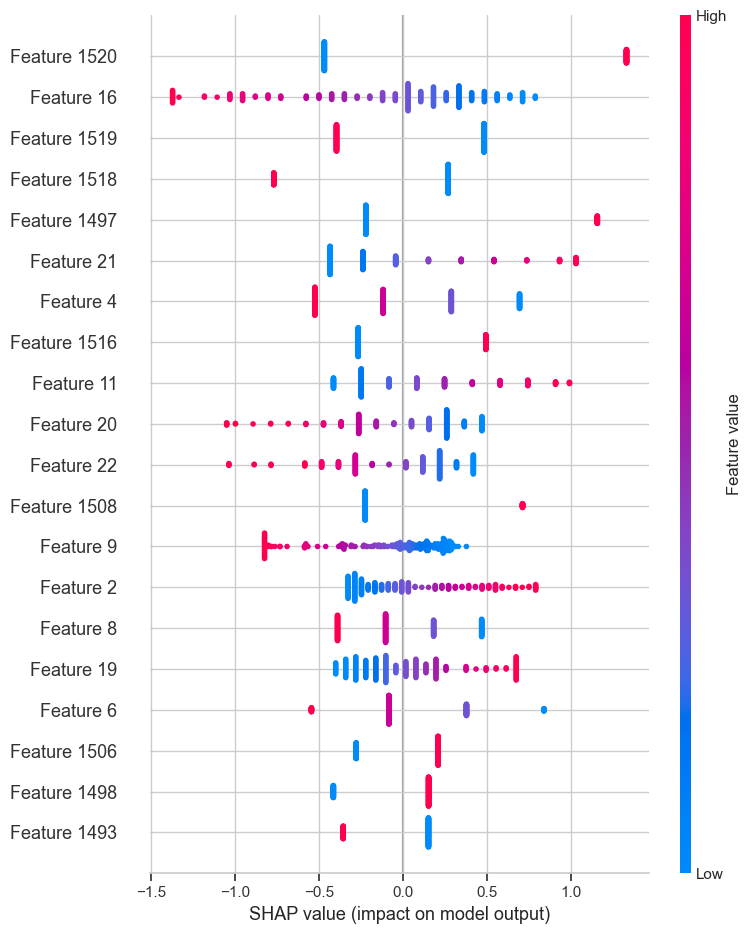

In [8]:

explainer = shap.Explainer(best_model.model, X_train)
shap_values = explainer(X_test[:200])

shap.summary_plot(shap_values, X_test[:200])
